# RDKit introduction

Install dependencies if necessary (uncomment and run):

In [8]:
# !pip install -r requirements.txt

## 1. Loading and visualizing molecules

SMILES strings are typically used for exchanging molecules. Let's load an example molecule - [ibuprofen](https://en.wikipedia.org/wiki/Ibuprofen) - with RDKit.

Things to note about RDKit:
- main module is `rdkit.Chem`, with most common functions directly available
- it uses CamelCase, following C++ conventions
- `MolFromSmiles` automatically performs basic sanitization and cleanup checks ([details](https://www.rdkit.org/docs/RDKit_Book.html#molecular-sanitization))
- Jupyter automatically renders molecules from the last line

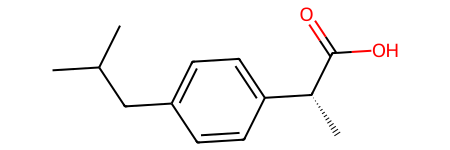

In [9]:
from rdkit.Chem import MolFromSmiles

smiles = "CC(C)Cc1ccc(cc1)[C@@H](C)C(=O)O"
ibuprofen_mol = MolFromSmiles(smiles)
ibuprofen_mol

Note that SMILES is not unique. Each software deterministically outputs its own **canonical SMILES**, but they differ between programs.

In [10]:
from rdkit.Chem import MolToSmiles

MolToSmiles(ibuprofen_mol)

'CC(C)Cc1ccc([C@@H](C)C(=O)O)cc1'

If you need more control over drawing, or are using regular Python scripts, `rdkit.Chem.Draw` contains necessary functions. It operates on `pillow` images, which are sometimes much less convenient than `matplotlib` plots.

<class 'PIL.PngImagePlugin.PngImageFile'>


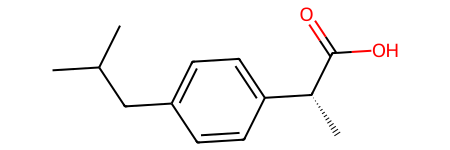

In [11]:
from rdkit.Chem.Draw import MolToImage


img = MolToImage(ibuprofen_mol)
print(type(img))
ibuprofen_mol

### Exercise 1

Read [caffeine molecule](https://en.wikipedia.org/wiki/Caffeine) from Wikipedia and plot it.

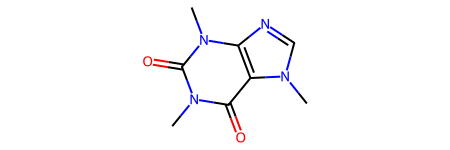

In [12]:
from rdkit.Chem import MolFromSmiles

caffeine_smiles = "CN1C=NC2=C1C(=O)N(C(=O)N2C)C"
caffeine_mol = MolFromSmiles(caffeine_smiles)
caffeine_mol

Note that RDKit by default uses **implicit hydrogens** where possible. To use them explicitly, e.g. for drawing, we use `AddHs` function. It returns new molecule with all hydrogens explicitly present.

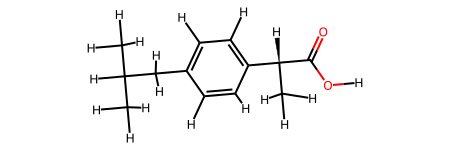

In [13]:
from rdkit.Chem import AddHs

AddHs(ibuprofen_mol)

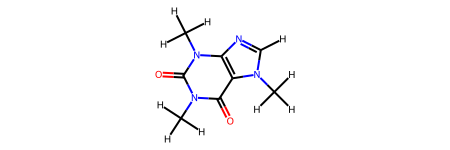

In [14]:
AddHs(caffeine_mol)

## 2. Atoms, bonds, rings

Molecules (`Mol` class) are built of atoms (`Atom` class) and bonds (`Bond` class). They are numbered, but everything on graphs is **permutation invariant**, i.e. this order is artificial, and purely for convenience.

Rings are simply sequences of atoms and bonds. Information about them is in `RingInfo` object for each molecule.

All are available in `rdkit.Chem.rdchem` ([docs](https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html)), but also in `rdkit.Chem`.

RDKit is very explicit about getting many objects. No typical Python convenience for iteration or nice printing by default!

In [15]:
for atom in ibuprofen_mol.GetAtoms():
    print(atom)

In [16]:
for atom in ibuprofen_mol.GetAtoms():
    print(f"{atom.GetIdx():2}", atom.GetAtomicNum(), atom.GetSymbol())

 0 6 C
 1 6 C
 2 6 C
 3 6 C
 4 6 C
 5 6 C
 6 6 C
 7 6 C
 8 6 C
 9 6 C
10 6 C
11 6 C
12 6 C
13 8 O
14 8 O


In [17]:
for bond in ibuprofen_mol.GetBonds():
    begin_atom = bond.GetBeginAtom()
    end_atom = bond.GetEndAtom()
    print(
        f"{bond.GetIdx():2}",
        begin_atom.GetSymbol(),
        end_atom.GetSymbol(),
        f"{bond.GetBondType()}",
    )

 0 C C SINGLE
 1 C C SINGLE
 2 C C SINGLE
 3 C C SINGLE
 4 C C AROMATIC
 5 C C AROMATIC
 6 C C AROMATIC
 7 C C AROMATIC
 8 C C AROMATIC
 9 C C SINGLE
10 C C SINGLE
11 C C SINGLE
12 C O DOUBLE
13 C O SINGLE
14 C C AROMATIC


There is no easy way to know which atom exactly has a given index. To plot this, we have to explicitly use `SetAtomMapNum` and assign the atom its own index as a number.

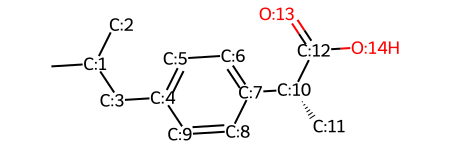

In [18]:
for atom in ibuprofen_mol.GetAtoms():
    atom.SetAtomMapNum(atom.GetIdx())

ibuprofen_mol

### Exercise 2

Counts of elements and bond types are arguably the simplest features available in chemistry. We used it e.g. in [MOLTOP model](https://arxiv.org/abs/2407.12136).

Implement `get_simple_element_counts` function, which returns tuple with 3 integers: counts of carbons, oxygens, and nitrogens.

In [19]:
from rdkit.Chem import Mol


def get_simple_element_counts(mol: Mol) -> tuple[int, int, int]:
    carbons = 0
    oxygens = 0
    nitrogens = 0
    
    for atom in mol.GetAtoms():
        match atom.GetSymbol():
            case "C":
                carbons += 1
            case "O":
                oxygens += 1
            case "N":
                nitrogens += 1

    return carbons, oxygens, nitrogens

In [20]:
assert get_simple_element_counts(ibuprofen_mol) == (13, 2, 0)
assert get_simple_element_counts(caffeine_mol) == (8, 2, 4)

carbons, oxygens, nitrogens = get_simple_element_counts(ibuprofen_mol)
print(f"Ibuprofen | carbons: {carbons}, oxygens: {oxygens}, nitrogens: {nitrogens}")

carbons, oxygens, nitrogens = get_simple_element_counts(caffeine_mol)
print(f"Caffeine  | carbons: {carbons}, oxygens: {oxygens}, nitrogens: {nitrogens}")

Ibuprofen | carbons: 13, oxygens: 2, nitrogens: 0
Caffeine  | carbons: 8, oxygens: 2, nitrogens: 4


## 3. Rings

Rings information can be obtained with `.GetRingInfo()`. Note that its `.AtomRings()` method returns atom indexes.

In [21]:
ri = ibuprofen_mol.GetRingInfo()

print(f"Number of rings: {ri.NumRings()}")
print(f"Rings: {ri.AtomRings()}")

Number of rings: 1
Rings: ((4, 9, 8, 7, 6, 5),)


### Exercise 3

Implement function `get_num_aromatic_rings`, which counts the **aromatic rings** in a molecule. Ring is aromatic if it consists only of aromatic atoms (or bonds, it's equivalent). Both atoms and bonds have `.GetIsAromatic()` method, which checks aromaticity. Molecules have `.GetAtomWithIdx()` method to get atom by index.

Test it on ibuprofen and caffeine molecules.

In [22]:
from typing import Iterable


def get_num_aromatic_rings(mol: Mol) -> int:
    ri = mol.GetRingInfo()

    return sum(
        all(mol.GetAtomWithIdx(atom).GetIsAromatic() for atom in ring)
        for ring in ri.AtomRings()
    )

In [23]:
assert get_num_aromatic_rings(ibuprofen_mol) == 1
assert get_num_aromatic_rings(caffeine_mol) == 2

print(f"Ibuprofen aromatic rings: {get_num_aromatic_rings(ibuprofen_mol)}")
print(f"Caffeine aromatic rings: {get_num_aromatic_rings(caffeine_mol)}")

print("Solution is correct!")

Ibuprofen aromatic rings: 1
Caffeine aromatic rings: 2
Solution is correct!


## 4. Molecular descriptors

To use computational methods on molecules, we need to compute some numerical properties. In particular, **descriptors** are particular properties of molecule, for example:
- element counts
- bond type counts
- atomic masses
- electric charges
- various topological indexes

They are very interpretable features, and often quite fast to compute. Using many well-selected descriptors can result in powerful models for predicting more complex properties.

In RDKit, they are in a few different places, e.g. in `rdkit.Chem.Descriptors`.

**Molecular mass** (or weight) is the sum of masses of all atoms in a molecule, typically counted in [daltons (Da)](https://en.wikipedia.org/wiki/Dalton_(unit)). Too large molecules are more rarely used, since it's hard for them to go through membranes.

In [24]:
from rdkit.Chem.Descriptors import MolWt


MolWt(ibuprofen_mol)

206.28499999999997

**Partition coefficient P** measures **lipophilicity** of molecule, i.e. how well it dissolves into fats (lipids). If molecule is lipophilic, it is also hydrophobic, i.e. does not dissolve well in water. This is also very important, since it strongly affects how easily the drug can reach its intended target in the body, and how well it will work when it reaches its target. Fortunately, it can be shown that we can quite well approximated by simple atomic contributions. Each element has its own contribution (positive or negative), and we sum them for a molecule. For details, see:
> Wildman, S.A. and Crippen, G.M. (1999) "Prediction of Physicochemical Parameters by Atomic Contribution" Journal of Chemical Information and Computer Sciences, 39, 868-873. ([link](http://dx.doi.org/10.1021/ci990307l))

Other references:
- [LogP - Making Sense of the Value](https://www.acdlabs.com/wp-content/uploads/download/app/physchem/making_sense.pdf)
- [Understanding Lipinski’s Rule of 5 and the Role of LogP Value in Drug Design and Development](https://www.sailife.com/understanding-lipinskis-rule-of-5-and-the-role-of-logp-value-in-drug-design-and-development/)

In [25]:
from rdkit.Chem.Crippen import MolLogP


MolLogP(ibuprofen_mol)

3.073200000000001

**Topological indices** describe the topology, or shape of the molecule, by simple numerical statistics. There are a lot, since they are closely tied to mathematics and graph theory, and molecules are graphs. It turns out that simple statistics of e.g. shortest paths of a molecule can be quite powerful in representing its properties as a single number (or a few such numbers). We used similar approaches in [LTP](https://arxiv.org/abs/2305.00724) and [MOLTOP](https://arxiv.org/abs/2407.12136) models.

Arguably the first computational approach in chemistry, using descriptors and statistics, was **Wiener index**:
> Wiener, H. (1947), "Structural determination of paraffin boiling points", Journal of the American Chemical Society, 1 (69): 17–20

It is defined as the sum of lengths of shortest paths between molecule atoms:
$$
W(G) = \frac{1}{2} \sum_{i=1}^N \sum_{j=1}^N dist(v_i, v_j)
$$

Length of shortest path is the minimal number of bonds to go through between atoms $i$ and $j$. Note we have to divide by 2 due to symmetry - here we sum both $dist(v_i, v_j)$ and $dist(v_j, v_i)$ for simplicity.

It turns out to be well correlated with many physico-chemical properties of alkanes (paraffins), e.g. boiling point (original Wiener's work), melting point, liquid density and viscocity, and more.

Other references:
- [Wikipedia page](https://en.wikipedia.org/wiki/Wiener_index)
- [Wolfram MathWorld page](https://mathworld.wolfram.com/WienerIndex.html)

Unfortunately, it is not implemented in RDKit.

### Exercise 4

Finish the implementation of `wiener_index()` function, which computes the Wiener index value for a molecule.

`GetDistanceMatrix()` function in RDKit returns a matrix of shortest path distances between atoms as a NumPy array.

In [26]:
import numpy as np
from rdkit.Chem import GetDistanceMatrix


def wiener_index(mol: Mol) -> int:
    return int(GetDistanceMatrix(mol).sum() / 2)


In [27]:
assert np.isclose(wiener_index(ibuprofen_mol), 404)
assert np.isclose(wiener_index(caffeine_mol), 258)

print(f"Ibuprofen Wiener index: {wiener_index(ibuprofen_mol)}")
print(f"Caffeine Wiener index: {wiener_index(caffeine_mol)}")

Ibuprofen Wiener index: 404
Caffeine Wiener index: 258


## 5. SMARTS patterns matching

SMARTS is like regular expressions (regex / regexp) for molecules. It allows us to define patterns in strings to detect substructures, e.g. methyl group, or aromatic ring of size N. They aren't very fast, but highly expressive and concise.

SMARTS matches, called **substructures**, are one of the most commonly used ML features, e.g. in searching and property prediction.

Example references:
- [Daylight - SMARTS - A Language for Describing Molecular Patterns](https://www.daylight.com/dayhtml/doc/theory/theory.smarts.html)
- [Daylight - SMARTS examples](https://www.daylight.com/dayhtml_tutorials/languages/smarts/smarts_examples.html)
- [Basic SMARTS patterns by R. Hanson](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-016-0160-4/tables/6)
- [SMARTS.plus visualizer](https://smarts.plus/)

In RDKit, they are `Mol` objects, created as `MolFromSmarts`. They typically are "templates" with wildcards, which can match any atoms. To match them, `Mol` has methods:
- `GetSubstructMatch()` - gets single match as list of atom indexes ([docs](https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html#rdkit.Chem.rdchem.Mol.GetSubstructMatch))
- `GetSubstructMatches()` - gets a list of matches aslists of atoms' indexes ([docs](https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html#rdkit.Chem.rdchem.Mol.GetSubstructMatches))
- `HasSubstructMatch()` - boolean whether we have at least 1 match ([docs](https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html#rdkit.Chem.rdchem.Mol.HasSubstructMatch))

Let's check 6-membered aromatic ring.

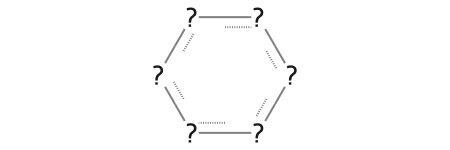

In [28]:
from rdkit.Chem import MolFromSmarts


ring_6_smarts = MolFromSmarts("a1aaaaa1")
ring_6_smarts

To draw methyl group $CH_3$, it's useful to explicitly draw all hydrogens. `AddHs` also works on molecules created from SMARTS.

Methyl group, implicit hydrogens:


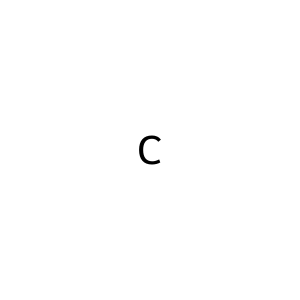

Methyl group, explicit hydrogens:


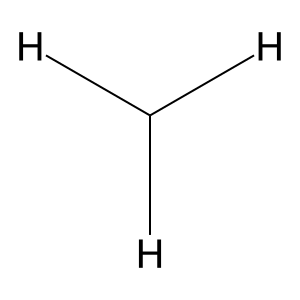

In [29]:
from rdkit.Chem import AddHs

methyl_smarts = MolFromSmarts("[CH3]")

print("Methyl group, implicit hydrogens:")
display(MolToImage(methyl_smarts))

print("Methyl group, explicit hydrogens:")
explicit_methyl_smarts = AddHs(methyl_smarts)
display(MolToImage(explicit_methyl_smarts))

### Exercise 5

Implement function `count_methyl_groups()`, which returns a number of methyl groups in a molecule.

In [30]:
def count_methyl_groups(mol: Mol) -> int:
    return len(mol.GetSubstructMatches(methyl_smarts))


In [31]:
assert count_methyl_groups(ibuprofen_mol) == 3
assert count_methyl_groups(caffeine_mol) == 3

print(f"Ibuprofen has {count_methyl_groups(ibuprofen_mol)} methyl groups")
print(f"Caffeine has {count_methyl_groups(caffeine_mol)} methyl groups")

Ibuprofen has 3 methyl groups
Caffeine has 3 methyl groups


Wiener index was originally used to predict melting point of alkanes (paraffins), which are crucial elements of fuels. However, he used a very small dataset. One of the largest and highest quality datasets for melting point of molecules is [Jean-Claude Bradley Double Plus Good Melting Point Dataset](https://figshare.com/articles/dataset/Jean_Claude_Bradley_Double_Plus_Good_Highly_Curated_and_Validated_Melting_Point_Dataset/1031638?file=1503991). It uses data from multiple data sources and measurements, not only for alkanes.

1. Download the dataset, read the CSV with Pandas.
2. Get SMILES from `smiles` column and transform them to molecules.
3. Get labels from `y` column - melting points in Celcius degrees.
4. Some SMILES cannot be parsed by RDKit, and result in `None` molecules - remove those samples.
5. Keep only alkanes, by using SMARTS `"[CX4]"`. If a molecule has such a match, it's an alkane.
6. Visualize `y` on a histogram. Print minimal, maximal and median values. This will help you understand the target values.
7. Wiener also suggested *polarity number* in his paper, which is number of shortest paths with length exactly 3. Implement `polarity_number()` function, which computes this feature.
8. For each molecule, extract features using functions from above:
   - Wiener index
   - polarity number
   - number of aromatic rings
   - molecular weight
   - logP
10. Split molecules with random split into train-test in 75-25% proportions with scikit-learn.
11. Train a simple linear regression. Calculate and print MAE and $R^2$ on training and testing dataset.
12. Many papers about predicting physico-chemical properties of molecules use polynomial regression. Add polynomial features with degree 3 (`PolynomialFeatures` in scikit-learn) and re-run the regression. Compare MAE and $R^2$ values to plain linear regression.

## Bonus exercise

Number of molecules: 3041
Number of valid molecules: 3025
Number of alkanes: 2193


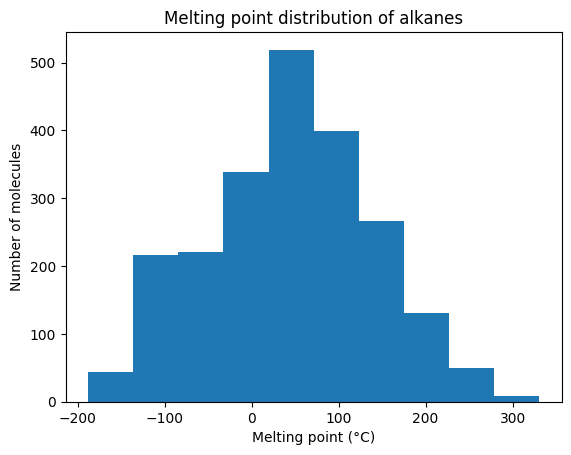

Min melting point: -188.0°C
Max melting point: 330.5°C
Median melting point: 48.0°C


In [49]:
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import RDLogger

RDLogger.DisableLog('rdApp.*')

dataset = pd.read_excel("data/BradleyDoublePlusGoodMeltingPointDataset.xlsx")
dataset.head()

smiles = dataset["smiles"]
mpC = dataset["mpC"]
print(f"Number of molecules: {len(smiles)}")

mols = [MolFromSmiles(s) for s in smiles]
valid_mols_mask = [mol is not None for mol in mols]
mols = np.array(mols)[valid_mols_mask]
mpC = np.array(mpC)[valid_mols_mask]
print(f"Number of valid molecules: {len(mols)}")

alkane_smarts = MolFromSmarts("[CX4]")
alkan_mols_mask = [mol.HasSubstructMatch(alkane_smarts) for mol in mols]
mols = mols[alkan_mols_mask]
mpC = mpC[alkan_mols_mask]
print(f"Number of alkanes: {len(mols)}")

plt.hist(mpC)
plt.xlabel("Melting point (°C)")
plt.ylabel("Number of molecules")
plt.title("Melting point distribution of alkanes")
plt.show()

min_mpC = mpC.min()
max_mpC = mpC.max()
median_mpC = np.median(mpC)

print(f"Min melting point: {min_mpC}°C")
print(f"Max melting point: {max_mpC}°C")
print(f"Median melting point: {median_mpC}°C")

In [ ]:
def polarity_number(mol: Mol) -> int:
    return np.sum(GetDistanceMatrix(mol) == 3) // 2

X = [
        [
            wiener_index(mol),
            polarity_number(mol),
            get_num_aromatic_rings(mol),
            MolWt(mol),
            MolLogP(mol),
        ]
        for mol in mols
    ]

Y = mpC

In [68]:
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    mean_absolute_error,
    r2_score,
)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)
y_pred = lin_reg.predict(X_test)
print(f"MAE: {mean_absolute_error(Y_test, y_pred):.2f}")
print(f"R^2 score: {r2_score(Y_test, y_pred):.2f}")

MAE: 49.73
R^2 score: 0.57


In [69]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

poly_reg = make_pipeline(PolynomialFeatures(3), LinearRegression())
poly_reg.fit(X_train, Y_train)
y_pred = poly_reg.predict(X_test)
print(f"MAE: {mean_absolute_error(Y_test, y_pred):.2f}")
print(f"R^2 score: {r2_score(Y_test, y_pred):.2f}")

MAE: 40.23
R^2 score: 0.63
